In [2]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
swarms = {}
for file in os.listdir('./temp_swarms/'):
    swarm_name = file.replace('.swm','')
    swarms[swarm_name] = SwarmManager.load(os.path.join('temp_swarms', file))

In [5]:
campaign_dict = {}
for swarm_name, smgr in swarms.items():
        smgr = swarms[swarm_name]
        campaign_dict[swarm_name] = smgr.swarm_picked.sum(axis=1)
   
    
campaign_portfolio = pd.DataFrame(campaign_dict)

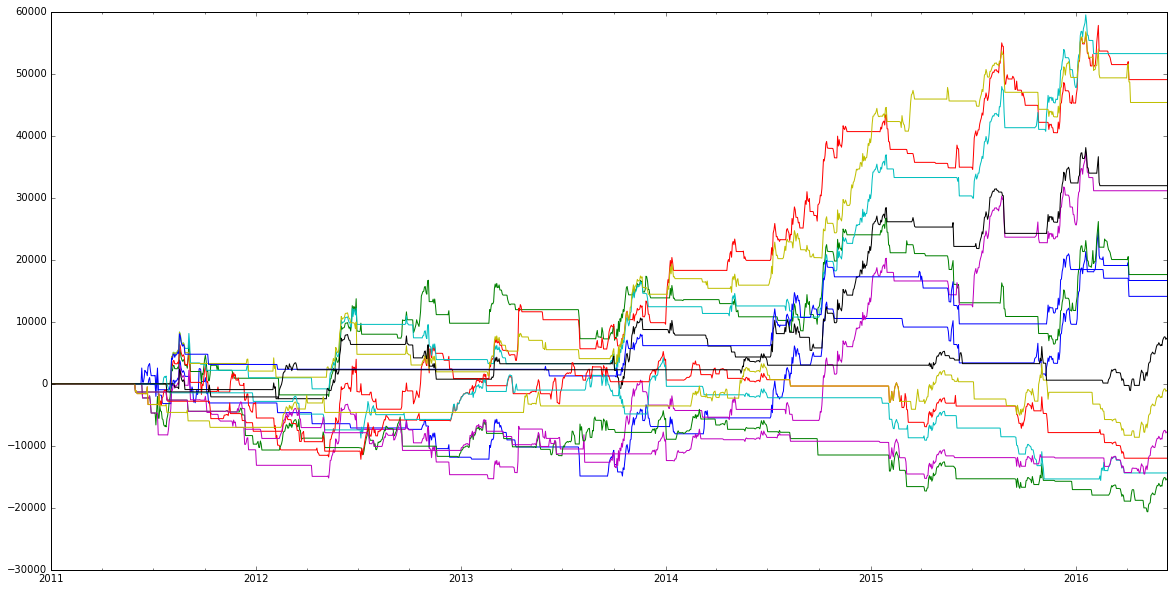

In [6]:
figsize(20,10)
campaign_portfolio.plot(legend=False)

## Rng strategies

In [7]:
#
# random time series
#
df = pd.DataFrame()
for i in range(5):
    
    date = pd.date_range(start='2016-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [8]:
# Real swarms
df = campaign_portfolio

# Rng strategies
#df = df

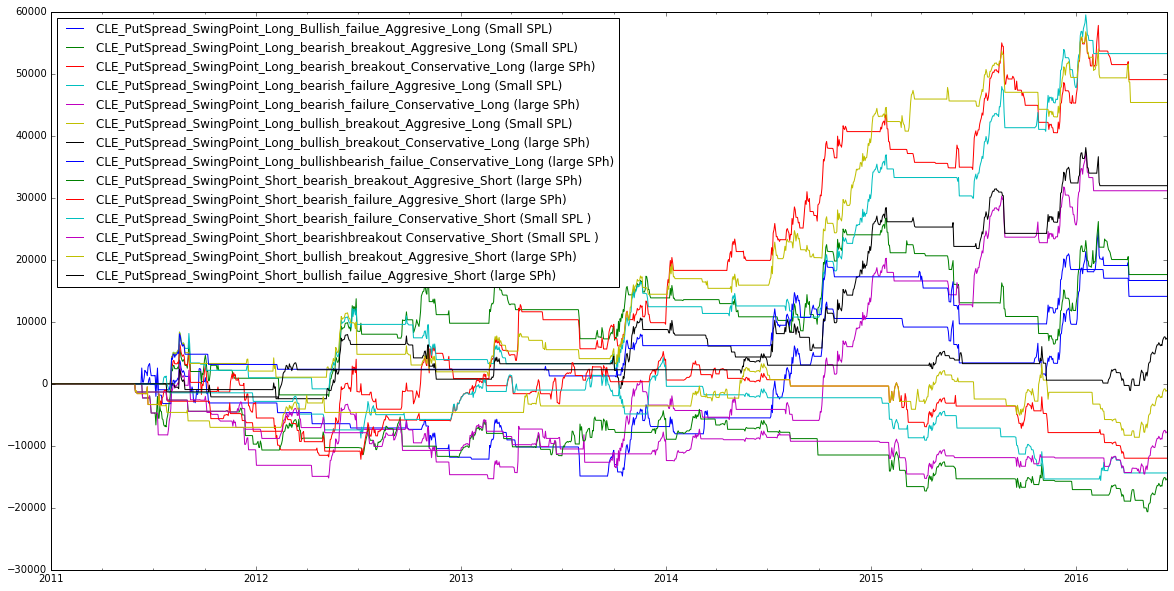

In [9]:
df.plot()

# Metrics calculation

In [10]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [11]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [12]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
316,2011-06-06,2011-05-30,23,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearish_breakou...
317,2011-06-06,2011-05-30,23,-1584.0,-1584.0,-0.590247,0.112108,-1.000000,20.000000,CLE_PutSpread_SwingPoint_Short_bearish_failure...
319,2011-06-06,2011-05-30,23,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearishbreakout...
320,2011-06-06,2011-05-30,23,-1584.0,-1584.0,-0.590247,0.112108,-1.000000,20.000000,CLE_PutSpread_SwingPoint_Short_bullish_breakou...
322,2011-06-13,2011-06-06,24,-24.0,2552.0,0.494171,107.333333,106.333333,20.000000,CLE_PutSpread_SwingPoint_Long_Bullish_failue_A...
323,2011-06-13,2011-06-06,24,-24.0,-24.0,-0.500000,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Long_bearish_breakout...
326,2011-06-13,2011-06-06,24,-24.0,-24.0,-0.500000,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Long_bearish_failure_...
330,2011-06-13,2011-06-06,24,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearish_breakou...
331,2011-06-13,2011-06-06,24,-1584.0,-1584.0,-0.590247,0.112108,-1.000000,20.000000,CLE_PutSpread_SwingPoint_Short_bearish_failure...
333,2011-06-13,2011-06-06,24,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearishbreakout...


## Statistics rank calculation

In [13]:
rank_scores_l = []
rank_summary_l = []

for i in stats_df.rebalance_index.unique():

    for strat in stats_df[stats_df.rebalance_index == i].strategy:

        for col in stats_df[stats_df.rebalance_index == i].columns:
            if 'stats' in col:

                # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
                metric_quantile0 = stats_df[col].quantile(0.0)
                metric_quantile10 = stats_df[col].quantile(0.1)
                metric_quantile20 = stats_df[col].quantile(0.2)
                metric_quantile30 = stats_df[col].quantile(0.3)
                metric_quantile40 = stats_df[col].quantile(0.4)
                metric_quantile50 = stats_df[col].quantile(0.5)
                metric_quantile60 = stats_df[col].quantile(0.6)
                metric_quantile70 = stats_df[col].quantile(0.7)
                metric_quantile80 = stats_df[col].quantile(0.8)
                metric_quantile90 = stats_df[col].quantile(0.9)
                metric_quantile100 = stats_df[col].quantile(1)

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric < metric_quantile10:
                    rank_scores_l.append(0)

                elif strategy_stats_metric > metric_quantile10 and strategy_stats_metric < metric_quantile20:
                    rank_scores_l.append(1)

                elif strategy_stats_metric > metric_quantile20 and strategy_stats_metric < metric_quantile30:
                    rank_scores_l.append(2)

                elif strategy_stats_metric > metric_quantile30 and strategy_stats_metric < metric_quantile40:
                    rank_scores_l.append(3)

                elif strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50:
                    rank_scores_l.append(4)

                elif strategy_stats_metric > metric_quantile50 and strategy_stats_metric < metric_quantile60:
                    rank_scores_l.append(5)

                elif strategy_stats_metric > metric_quantile60 and strategy_stats_metric < metric_quantile70:
                    rank_scores_l.append(6)

                elif strategy_stats_metric > metric_quantile70 and strategy_stats_metric < metric_quantile80:
                    rank_scores_l.append(7)

                elif strategy_stats_metric > metric_quantile80 and strategy_stats_metric < metric_quantile90:
                    rank_scores_l.append(8)

                elif strategy_stats_metric > metric_quantile90 and strategy_stats_metric < metric_quantile100:
                    rank_scores_l.append(9)

                elif strategy_stats_metric == metric_quantile100:
                    rank_scores_l.append(10)

                # For debugging purposes

                #print(i)
                #print(col)
                #print('50 quantile---',metric_quantile50)
                #print(strat)
                #print(strategy_stats_metric)
        #print('rank_score------', np.sum(rank_scores_l))

    
        rank_summary_l.append(np.sum(rank_scores_l))        
        rank_scores_l = []
    print('rebalance index ---', i)

rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --- 46
rebalance index --- 47
rebalance index --- 48
rebalance index --- 49
rebalance index --- 50
rebalance index --- 51
rebalance index --- 52
rebalance index --- 53
rebalance index --- 54
rebalance index --- 55
rebalance index --- 56
rebalance index --- 57
rebalance index --- 58
rebalance index --- 59
rebalance index --- 60
rebalance index --- 61
rebalance index --- 62
rebalance index --- 63
rebalance index --- 64
rebalance index --- 65
rebalance i

In [14]:
stats_df['rank_score'] = rank_summary_l

In [15]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
316,2011-06-06,2011-05-30,23,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearish_breakou...,12
317,2011-06-06,2011-05-30,23,-1584.0,-1584.0,-0.590247,0.112108,-1.000000,20.000000,CLE_PutSpread_SwingPoint_Short_bearish_failure...,14
319,2011-06-06,2011-05-30,23,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearishbreakout...,12
320,2011-06-06,2011-05-30,23,-1584.0,-1584.0,-0.590247,0.112108,-1.000000,20.000000,CLE_PutSpread_SwingPoint_Short_bullish_breakou...,14
322,2011-06-13,2011-06-06,24,-24.0,2552.0,0.494171,107.333333,106.333333,20.000000,CLE_PutSpread_SwingPoint_Long_Bullish_failue_A...,27
323,2011-06-13,2011-06-06,24,-24.0,-24.0,-0.500000,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Long_bearish_breakout...,9
326,2011-06-13,2011-06-06,24,-24.0,-24.0,-0.500000,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Long_bearish_failure_...,9
330,2011-06-13,2011-06-06,24,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearish_breakou...,12
331,2011-06-13,2011-06-06,24,-1584.0,-1584.0,-0.590247,0.112108,-1.000000,20.000000,CLE_PutSpread_SwingPoint_Short_bearish_failure...,14
333,2011-06-13,2011-06-06,24,-1324.0,-1324.0,-0.511509,0.000001,-1.000000,0.000001,CLE_PutSpread_SwingPoint_Short_bearishbreakout...,12


### Strategies picker

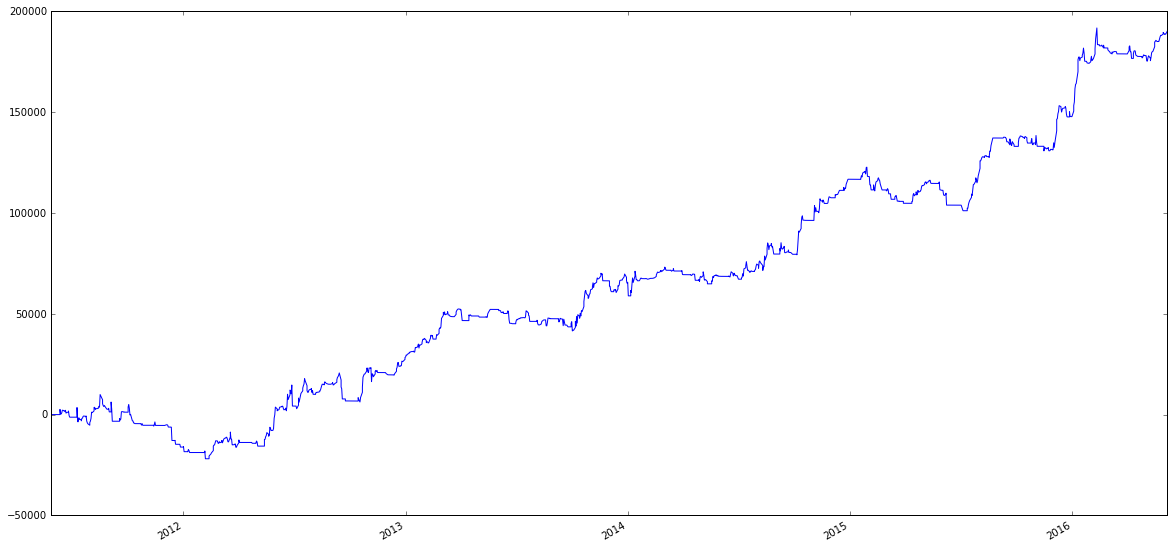

In [36]:
# Trade-by-trade pnl
test_df = df.diff()

summary_eqty = pd.Series()
# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future looking)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:2]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-4:]
        
        if len(summary_eqty) == 0:
            summary_eqty = test_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)
            
            #summary_eqty = test_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)
            
        else:
            summary_eqty = summary_eqty.append(test_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))

            #summary_eqty = summary_eqty.append(test_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
        #print(picked_strats)
        #break
summary_eqty.cumsum().plot()

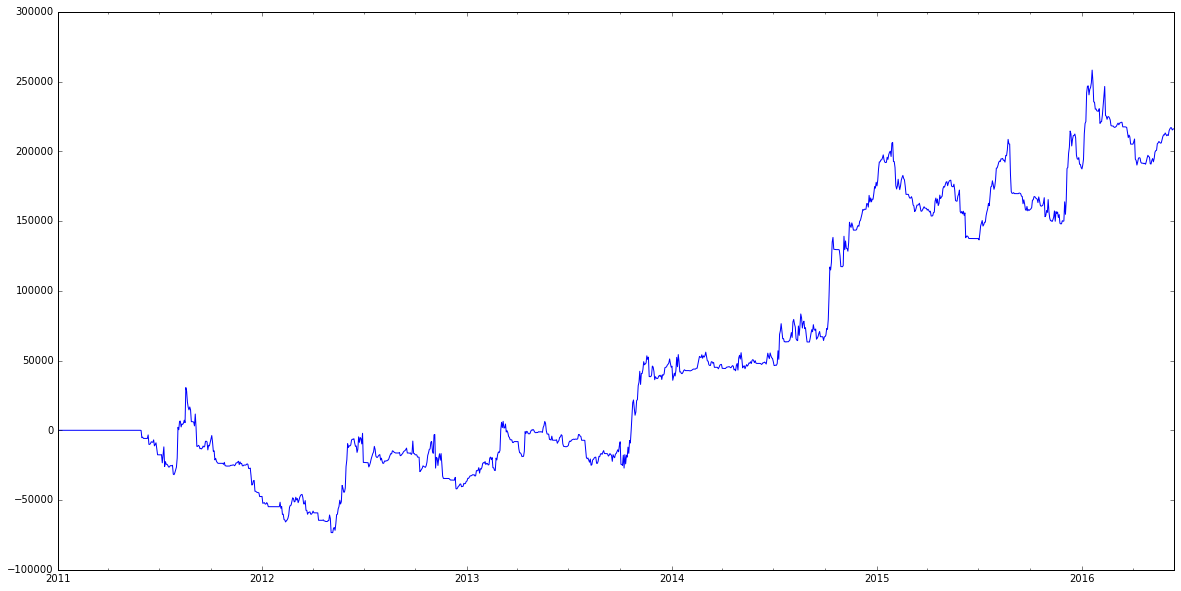

In [27]:
df.sum(axis=1).plot()

In [281]:
%watermark -d -m -v -p cython

ERROR: Line magic function `%watermark` not found.
